In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import pytz
import missingno as msno
import altair as alt


[Shift time for TimeCreatedSystemTime to UTC](#timeshift)
[Join machines to events](#machines_events)


In [2]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [3]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [4]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [5]:
# Visualize codes by EventName in df_win['EventName'].
def get_compare_chart(in_data, in_col, in_title):
 count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0:'count'})
 # Sort order for chart
 count_df2.sort_values('count', ascending = False, inplace=True)
 sort_order = [val for val in count_df2[in_col].unique()]
 out_chart = alt.Chart(count_df2).mark_bar().encode(
     x = alt.X('count:Q'),
     y = alt.Y(in_col+':N', sort=sort_order),
     tooltip ='count:Q'
 ).properties(title = in_title)
 return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
  for eventname in eventname_list:
    current_df = in_df[in_df['EventName'] == eventname]
    out_chart = get_compare_chart(current_df, visualize_attr, f'Counts of {visualize_attr} types for {eventname} events')
    yield out_chart
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [6]:
# current_chart = next(charts)
# current_chart

In [7]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [8]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [9]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [10]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [11]:
events = pd.concat([df_app, df_win, df_hang])

In [12]:
# Dropping columns with nothing in them.
events.dropna(axis=1, how='all', inplace=True)

<AxesSubplot:>

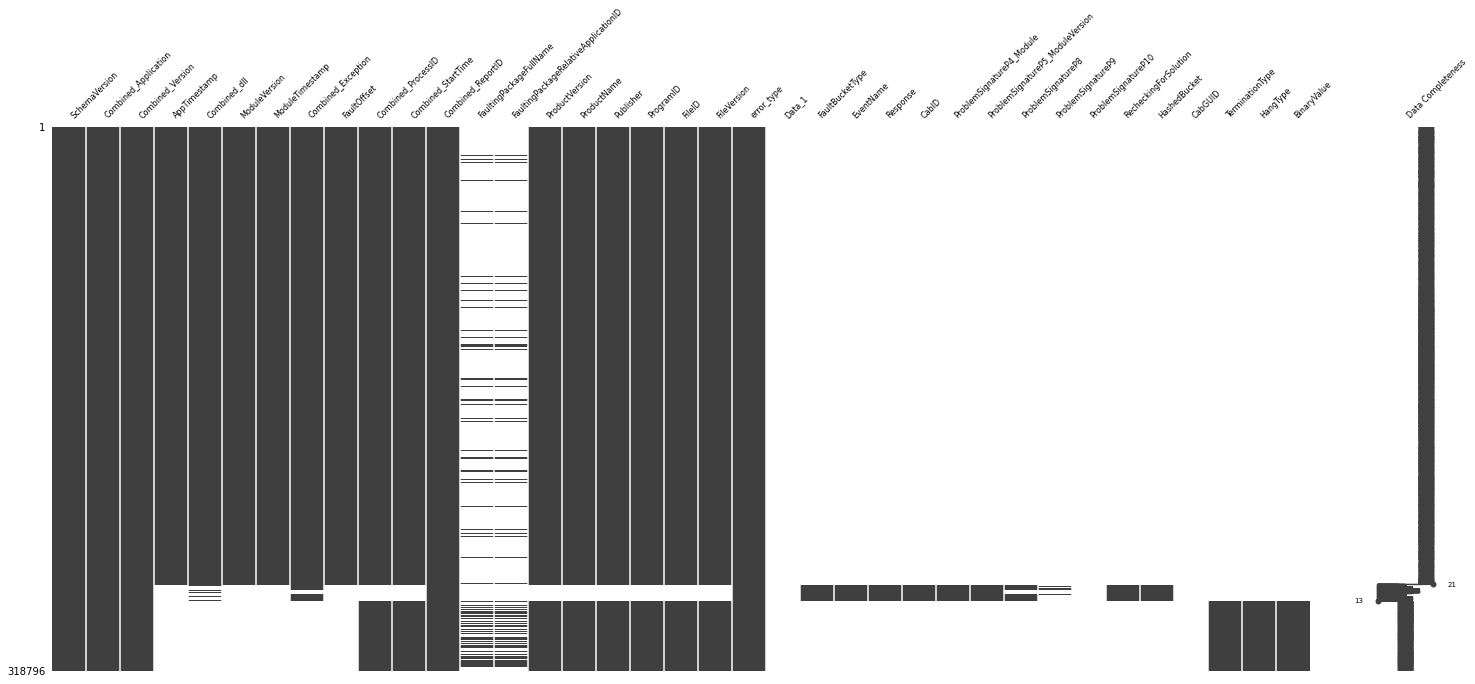

In [13]:
msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)


<a id='timeshift'></a>
# Shift TimeCreatedSystemTime to Central time to match INCs.


In [14]:
# Convert local time values to Central.
def convert_to_cst(df, utc_column_name, cst_column_name):

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

events = convert_to_cst(events, utc_column_name='TimeCreatedSystemTime', cst_column_name='CreatedSystemTime_CST')

In [15]:
# Check all times are -05:00 or -06:00 from UTC (Daylight Savings Time).
events[['TimeCreatedSystemTime', 'CreatedSystemTime_CST']].sample(5)

,TimeCreatedSystemTime,CreatedSystemTime_CST
8993,2023-03-24 15:28:11.323000+00:00,2023-03-24 10:28:11.323000-05:00
5701,2023-01-23 13:52:57.873000+00:00,2023-01-23 07:52:57.873000-06:00
8291,2023-05-22 14:57:51.340000+00:00,2023-05-22 09:57:51.340000-05:00
8288,2023-04-15 05:01:22.097000+00:00,2023-04-15 00:01:22.097000-05:00
3961,2023-05-14 17:44:35.403000+00:00,2023-05-14 12:44:35.403000-05:00


In [16]:
events['CreatedSystemTime_CST_formatted'] = events['CreatedSystemTime_CST'].dt.strftime('%Y-%m-%d')


<a id="machines_events"></a>
# Join Machine data with Events data.


In [17]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

In [18]:
# msno.matrix(incs, labels=True, fontsize=8)

In [19]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [20]:
# Join machine name to events by internal date and item key.
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'], how='left')

In [21]:
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

<AxesSubplot:>

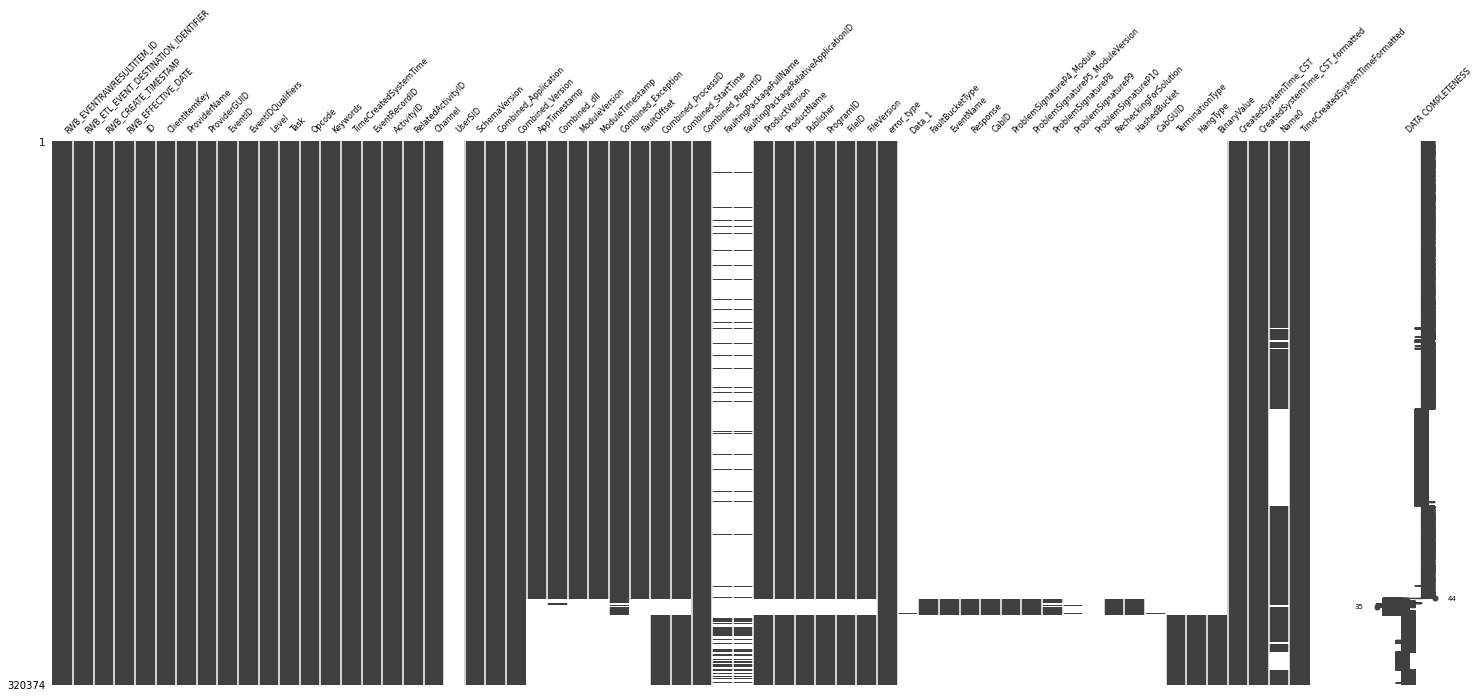

In [22]:
msno.matrix(machines_events, labels=True, fontsize=8)

In [23]:
machines_events[machines_events['error_type'].isin(['Application', 'Hang'])].sample(5)

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,RecheckingForSolution,HashedBucket,CabGUID,TerminationType,HangType,BinaryValue,CreatedSystemTime_CST,CreatedSystemTime_CST_formatted,Name0,TimeCreatedSystemTimeFormatted
61390,3102907,3191,2023-03-03 08:46:17 -06:00,2023-03-03,72057594082954012,16802201,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-26 22:36:08.807000-06:00,2023-02-26,MIL-L-U29810,2023-02-27
294391,1519628,1163,2023-01-30 09:09:03 -06:00,2023-01-30,72057594081365168,16814761,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,4294967295,Quiesce,510075006900650073006300650000000000,2023-01-30 06:33:12.890000-06:00,2023-01-30,MIL-L-U32750,2023-01-30
40547,3734368,4059,2023-03-17 08:46:11 -05:00,2023-03-17,72057594083619224,16816005,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-15 07:54:10.380000-05:00,2023-03-15,MIL-L-U32085,2023-03-15
254573,5505694,6291,2023-04-22 08:46:21 -05:00,2023-04-22,72057594085409146,16814662,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-19 02:30:02.717000-05:00,2023-04-19,CHI-L-U31118,2023-04-19
250290,5630442,6477,2023-04-25 08:46:22 -05:00,2023-04-25,72057594085534556,16809018,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-19 17:15:10.030000-05:00,2023-04-19,MIL-L-U32029,2023-04-19



# Join INCs to machine + event.


In [24]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

In [25]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')

In [26]:
# Join INCs to events on 1. Machine name, and 2. The event and the INC both occurred on the same day.
incs_merged = machines_events.merge(incs, left_on=['Name0', 'CreatedSystemTime_CST_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [27]:
print(len(incs_merged))

320374


In [28]:
# Dropping columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [29]:
# msno.matrix(incs_merged, labels=True, fontsize=7)

In [30]:
# Should be many more. Why only still 4,000?
print(len(incs), "INC rows originally")
print("Now", incs_merged['number'].notnull().sum())

6104 INC rows originally
Now 4083


In [31]:
incs_merged.sample(10)[[
    'error_type',
    # 'OSVersion',
    'Combined_Application',
    'Combined_dll',
    # 'FaultingPackageFullName',
    'ProductName',
    'category',
    'subcategory',
    'short_description_NER'
]]

,error_type,Combined_Application,Combined_dll,ProductName,category,subcategory,short_description_NER
121703,Application,POWERPNT.EXE,igd10iumd32.dll,Microsoft Office,NaN,NaN,NaN
67959,Application,AUDIODG.EXE,MaxxAudioRenderAVX64.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
117487,Application,WavesSvc64.exe,WavesSvc64.exe,Waves MaxxAudio,NaN,NaN,NaN
270485,Windows,Microsoft.YourPhone_1.23012.155.0_x64__8wekyb3...,NaN,NaN,NaN,NaN,NaN
100810,Application,EXCEL.EXE,b_pciuoeal.dll,Microsoft Office,NaN,NaN,NaN
54620,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
292079,Hang,svchost.exe,NaN,Microsoft® Windows® Operating System,NaN,NaN,NaN
144584,Application,32BitMAPIBroker.exe,ucrtbase.dll,Adobe Acrobat 32BitMAPIBroker,NaN,NaN,NaN
258674,Application,WavesSvc64.exe,WavesSvc64.exe,Waves MaxxAudio,NaN,NaN,NaN
82525,Application,IntelAudioService.exe,KERNELBASE.dll,IntelAudioService,NaN,NaN,NaN


In [32]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'CreatedSystemTime_CST_formatted',
    'CreatedSystemTime_CST',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]

,CreatedSystemTime_CST_formatted,CreatedSystemTime_CST,opened_at,opened_at_formatted,Name0,configuration_item,number,short_description_NER
74,2023-04-10,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
75,2023-04-10,2023-04-10 15:23:56.900000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
269500,2023-04-10,2023-04-10 12:35:27.050000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death


In [33]:
incs_merged['CreatedSystemTime_CST']

0        2023-04-10 09:27:47.370000-05:00
1        2023-04-11 07:41:53.913000-05:00
2        2023-04-10 14:09:04.523000-05:00
3        2023-04-10 07:58:45.063000-05:00
4        2023-04-10 07:58:54.250000-05:00
                       ...               
320369   2023-04-10 15:37:12.363000-05:00
320370   2023-04-12 10:50:18.360000-05:00
320371   2023-04-11 17:09:58.767000-05:00
320372   2023-04-05 09:13:37.730000-05:00
320373   2023-04-13 08:16:49.137000-05:00
Name: CreatedSystemTime_CST, Length: 320374, dtype: datetime64[ns, America/Chicago]

In [34]:
incs_merged['opened_at_utc'] = incs_merged['opened_at'].dt.tz_localize('UTC')

In [35]:
incs_merged.loc[74, 'CreatedSystemTime_CST']

Timestamp('2023-04-10 08:28:18.740000-0500', tz='America/Chicago')

In [36]:
incs_merged.loc[74, 'opened_at_utc']

Timestamp('2023-04-10 11:20:00+0000', tz='UTC')

In [37]:
# This event happened after the INC was filed, at 13:28 UTC.
incs_merged.loc[74, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_utc']

Timedelta('0 days 02:08:18.740000')

In [38]:
# Delete INCs across rows when the event occurs before the INC on the same day.
mask = incs_merged['CreatedSystemTime_CST'] >= incs_merged['opened_at_utc']
columns_to_set_none = incs.columns
incs_merged.loc[mask, columns_to_set_none] = None

In [39]:
# Looks like no 'CreatedSystemTime_CST value is > 'opened_at'.
incs_merged[incs_merged['number'].notnull()][['CreatedSystemTime_CST', 'opened_at', 'number']]

,CreatedSystemTime_CST,opened_at,number
502,2023-04-10 07:47:01.750000-05:00,2023-04-10 20:43:00,INC0516099
570,2023-04-10 07:29:33.643000-05:00,2023-04-10 17:39:00,INC0516019
571,2023-04-10 07:51:04.520000-05:00,2023-04-10 17:39:00,INC0516019
572,2023-04-10 10:59:19.490000-05:00,2023-04-10 17:39:00,INC0516019
635,2023-04-11 05:04:46.600000-05:00,2023-04-11 17:45:00,INC0516374
...,...,...,...
320201,2023-04-11 10:27:57.903000-05:00,2023-04-11 15:52:00,INC0516309
320202,2023-04-11 10:28:02.510000-05:00,2023-04-11 15:52:00,INC0516309
320346,2023-04-13 04:29:30.073000-05:00,2023-04-13 11:37:00,INC0516805
320347,2023-04-13 05:25:58.367000-05:00,2023-04-13 11:37:00,INC0516805


In [40]:
# Check to make sure. Positive = delete. Negative = keep.
(incs_merged['CreatedSystemTime_CST'] - incs_merged['opened_at_utc']).dropna()

74         0 days 02:08:18.740000
75         0 days 09:03:56.900000
502      -1 days +16:04:01.750000
570      -1 days +18:50:33.643000
571      -1 days +19:12:04.520000
                   ...           
320202   -1 days +23:36:02.510000
320346   -1 days +21:52:30.073000
320347   -1 days +22:48:58.367000
320348   -1 days +22:49:29.357000
320349     0 days 00:47:37.237000
Length: 4083, dtype: timedelta64[ns]

In [41]:
# Timedelta of -1 days (24h) + 16:04 = 8h 04m difference in true time.
incs_merged.loc[502, ['CreatedSystemTime_CST', 'opened_at_utc']]

CreatedSystemTime_CST    2023-04-10 07:47:01.750000-05:00
opened_at_utc                   2023-04-10 20:43:00+00:00
Name: 502, dtype: object


# Join Machines data with Boot data.


In [42]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


In [43]:
df_boot['error_type'] = 'Boot'

In [44]:
# What columns do all four event types have in common?
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [45]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [46]:
# Needs to be a str to join later w/ 'opened_at_formatted'.
df_boot['BootID_formatted'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [47]:
# Join machine name to boot events, similar to other section.
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])


# Join INCs to machine + boot.


In [48]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [49]:
print(incs_boot['number'].notnull().sum(), "Boot INCs")

5069 Boot INCs


In [50]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)


#### How many multiple INCs were filed on the same day for a given machine?


In [51]:
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

0


Series([], dtype: int64)


# Bring both DataFrames together.


In [52]:
incs_boot[incs_boot['number'].notnull()]

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted,count,dup,group_index_orig
86,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
87,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
88,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
89,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
90,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845889,1484152,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,3,16795890,2023-05-20 04:24:55.647,0,18555,...,0.0,Citrix VDA needed asap- CHE - D - U27461,CHE-D-U27461,12384.0,2023-05-19,CHE-D-U27461,2023-05-19,1.0,0.0,4362.0
845890,1484152,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,3,16795890,2023-05-20 04:24:55.647,0,18555,...,0.0,Citrix VDA needed asap- CHE - D - U27461,CHE-D-U27461,12384.0,2023-05-19,CHE-D-U27461,2023-05-19,1.0,0.0,4362.0
847673,1485125,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043643145,3,16792903,2023-05-20 11:23:57.840,0,14226,...,0.0,missing teams install,CLM-D-U25402,78.0,2023-05-19,NaN,2023-05-19,1.0,0.0,4368.0
847674,1485125,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043643145,3,16792903,2023-05-20 11:23:57.840,0,14226,...,0.0,missing teams install,CLM-D-U25402,78.0,2023-05-19,NaN,2023-05-19,1.0,0.0,4368.0


In [53]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

In [54]:
# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

In [55]:
# Drop all data for May 20th, 2023.
df = df[df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

<AxesSubplot:>

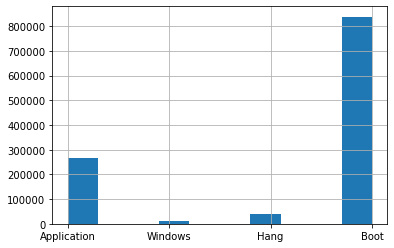

In [56]:
df['error_type'].hist()

In [57]:
df.dtypes

index                                     int64
RWB_EVENTRAWRESULTITEM_ID               float64
RWB_ETL_EVENT_DESTINATION_IDENTIFIER      int64
RWB_CREATE_TIMESTAMP                     object
RWB_EFFECTIVE_DATE                       object
                                         ...   
MachineName                              object
Reason                                   object
param5                                   object
ActionDescription                        object
BootID_formatted                         object
Length: 172, dtype: object

In [58]:
# How many boot events occurred after an INC was filed?
# df[df['error_type'] == 'Boot']['BootID'] - df[df['error_type'] == 'Boot']['opened_at_utc']

In [59]:
df.shape

(1155349, 172)


# Create num_events feature.


In [60]:
# num_events_df = pd.concat([machines_events, machines_boot])
num_events_df = events.copy()

In [61]:
num_events_df.columns

Index(['RWB_EVENTRAWRESULTITEM_ID', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'RWB_CREATE_TIMESTAMP', 'RWB_EFFECTIVE_DATE', 'ID', 'ClientItemKey',
       'ProviderName', 'ProviderGUID', 'EventID', 'EventIDQualifiers', 'Level',
       'Task', 'Opcode', 'Keywords', 'TimeCreatedSystemTime', 'EventRecordID',
       'ActivityID', 'RelatedActivityID', 'Channel', 'UserSID',
       'SchemaVersion', 'Combined_Application', 'Combined_Version',
       'AppTimestamp', 'Combined_dll', 'ModuleVersion', 'ModuleTimestamp',
       'Combined_Exception', 'FaultOffset', 'Combined_ProcessID',
       'Combined_StartTime', 'Combined_ReportID', 'FaultingPackageFullName',
       'FaultingPackageRelativeApplicationID', 'ProductVersion', 'ProductName',
       'Publisher', 'ProgramID', 'FileID', 'FileVersion', 'error_type',
       'Data_1', 'FaultBucketType', 'EventName', 'Response', 'CabID',
       'ProblemSignatureP4_Module', 'ProblemSignatureP5_ModuleVersion',
       'ProblemSignatureP8', 'ProblemSignatur

<AxesSubplot:>

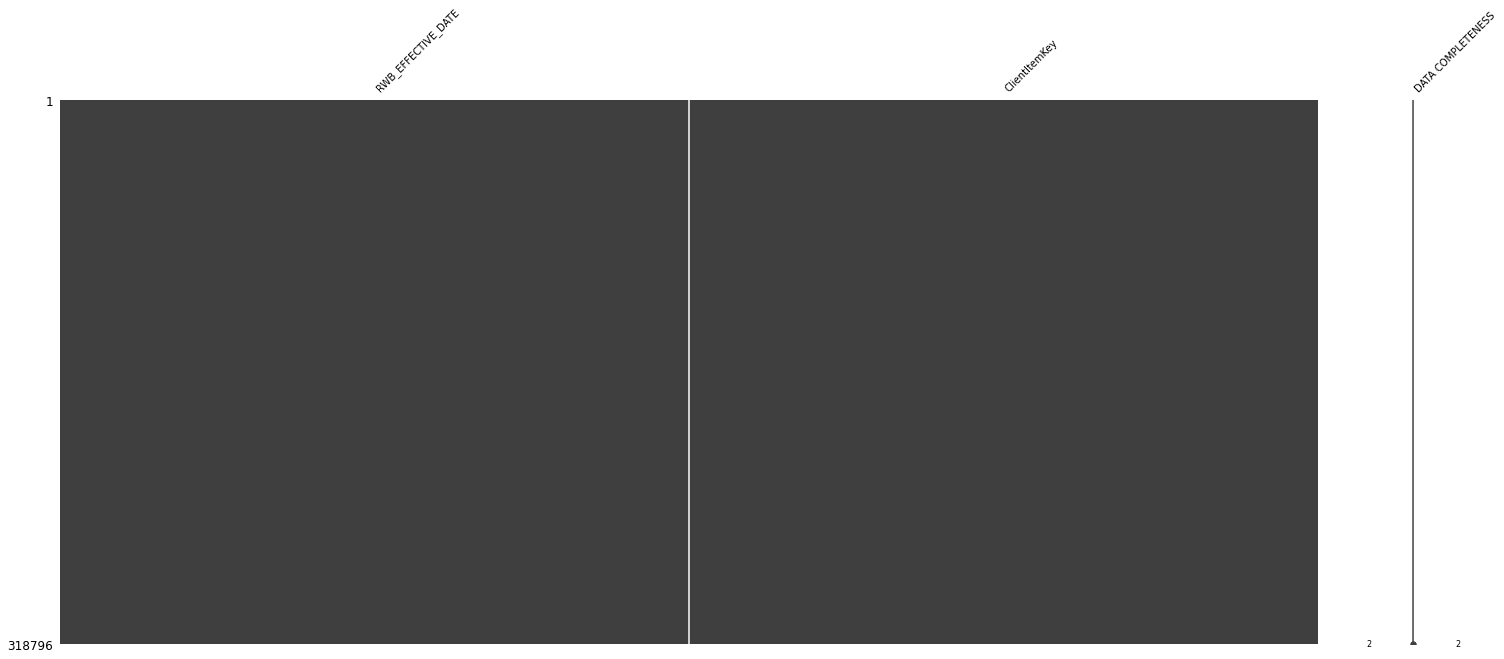

In [63]:
# msno.matrix(num_events_df[['RWB_EFFECTIVE_DATE', 'Name0', 'MachineName']], labels=True, fontsize=10)
msno.matrix(num_events_df[['RWB_EFFECTIVE_DATE', 'ClientItemKey']], labels=True, fontsize=10)

In [64]:
# Some events didn't have a machine successfully join.
num_events_df[num_events_df['ClientItemKey'].isnull()]

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,ProblemSignatureP9,ProblemSignatureP10,RecheckingForSolution,HashedBucket,CabGUID,TerminationType,HangType,BinaryValue,CreatedSystemTime_CST,CreatedSystemTime_CST_formatted


In [65]:
num_events = df.groupby(['RWB_EFFECTIVE_DATE', 'ClientItemKey']).agg('size').reset_index().rename(columns={0:'events'})
num_events

,RWB_EFFECTIVE_DATE,ClientItemKey,events
0,2022-08-30,16783564,11
1,2022-08-30,16783835,22
2,2022-08-30,16784042,32
3,2022-08-30,16784339,5
4,2022-08-30,16784657,5
...,...,...,...
532942,2023-07-04,16818858,2
532943,2023-07-04,16818889,1
532944,2023-07-04,16818928,8
532945,2023-07-04,16819002,1


In [66]:
num_events.to_parquet('../do_not_commit/Datasets/num_events.pq')


#### How many INCs contain direct reference to BSOD?


In [ ]:
df['short_description_NER'].unique()

In [ ]:
# How many short descriptions talk about BSODs?
len(df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

In [ ]:
# What is the frequency of each error type for BSOD tickets?
df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'Combined_Application', 'Combined_dll', 'Combined_Exception']]

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


#### What is the distribution of FaultApplicationName among INCs?


In [ ]:
df_check = df[df['error_type'] == 'Application']

In [ ]:
df_check['Combined_Application'].value_counts()


#### What is the distribution of modules among INCs?


In [ ]:
df_check['Combined_dll'].value_counts()


#### Which exception codes are most common among INCs?


In [ ]:
df_check[['Combined_Application', 'Combined_Exception']].value_counts()